# 3 class discrimination of trialtype
. 
### Using sklean and skflow. Comparison to each of the 4 mice

In [2]:
import tensorflow as tf
import tensorflow.contrib.learn as skflow
import numpy as np


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns 
import random
from scipy.signal import resample
from scipy.stats import zscore
from scipy import interp
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn import cross_validation

In [22]:
# data loading function
def data_loader(mouse_name):
    theta = pd.read_csv('~/work/whiskfree/data/theta_' + mouse_name + '.csv',header=None)
    kappa = pd.read_csv('~/work/whiskfree/data/kappa_' + mouse_name + '.csv',header=None)
    tt = pd.read_csv('~/work/whiskfree/data/trialtype_' + mouse_name + '.csv',header=None)
    ch = pd.read_csv('~/work/whiskfree/data/choice_' + mouse_name + '.csv',header=None)
    sess = pd.read_csv('~/work/whiskfree/data/session_' + mouse_name + '.csv',header=None)
    AB = pd.read_csv('~/work/whiskfree/data/AB_' + mouse_name + '.csv',header=None)
    return theta, kappa, tt, ch, sess, AB

def data_parser(theta,kappa,tt,ch,sess,AB):
    
    theta_r = np.array([[resample(theta.values.squeeze()[i,950:1440],50)] for i in range(0,theta.shape[0])])
    theta_r = zscore(theta_r.squeeze(),axis=None)

    kappa_r = np.array([[resample(kappa.values.squeeze()[i,950:1440],50)] for i in range(0,kappa.shape[0])])
    kappa_r = zscore(kappa_r.squeeze(),axis=None)

    kappa_df = pd.DataFrame(kappa_r)
    theta_df = pd.DataFrame(theta_r)

    both_df = pd.concat([theta_df,kappa_df],axis=1)
    
    clean1 = np.nan_to_num(tt) !=0
    clean2 = np.nan_to_num(ch) !=0
    clean = clean1&clean2
    tt_c = tt[clean].values

    ch_c = ch[clean].values
    
    s_c = sess[clean].values
    
    ab_c = AB[clean].values

    # tt_c = tt[tt.values !=0|3].values
    both = both_df[clean]
    # both_c = both[clean.squeeze(),:]
    both_c = both.values
    
    # keeping one hot vector for now (incase we want it later)
#     labs = np.eye(3)[tt_c.astype(int)-1]
    # y[np.arange(3), a] = 1
#     labs = labs.squeeze()
    
    return both_c, tt_c, ch_c, clean, s_c, ab_c

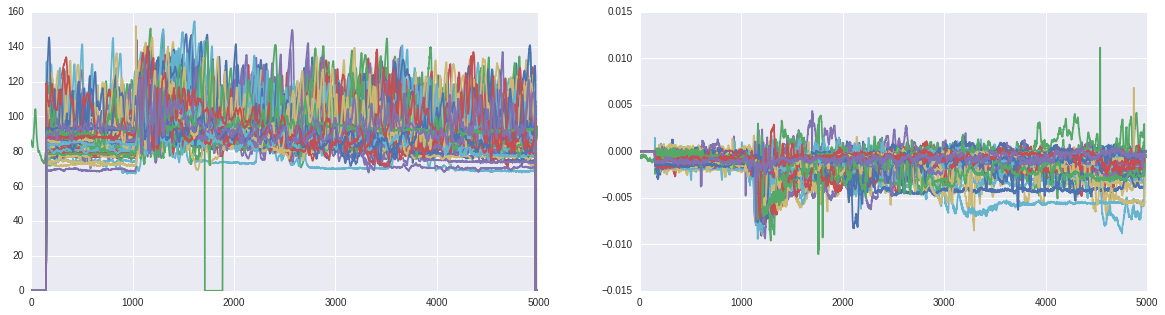

In [20]:
mouse_name = '36_r'
theta, kappa, tt, ch, sess, AB = data_loader(mouse_name)
fig, ax = plt.subplots(1,2,figsize=(20,5))
_ = ax[0].plot(theta[:100].T)
_ = ax[1].plot(kappa[:100].T)

In [21]:
AB_pol = np.nan_to_num(AB) !=0
ON_pol = np.nan_to_num(AB) ==0
cm_AB = confusion_matrix(tt[AB_pol],ch[AB_pol])
cm_ON = confusion_matrix(tt[ON_pol],ch[ON_pol])
print(cm_AB)
print(cm_ON)
print(accuracy_score(tt[AB_pol],ch[AB_pol]))
print(accuracy_score(tt[ON_pol],ch[ON_pol]))

[[ 13   0   0   0]
 [  0 293  42  47]
 [  0  63 213  42]
 [  0  85  25 220]]
[[  8   0   0   0]
 [  0 180  23  28]
 [  0  41 139  26]
 [  0  52  47 198]]
0.708533077661
0.707547169811


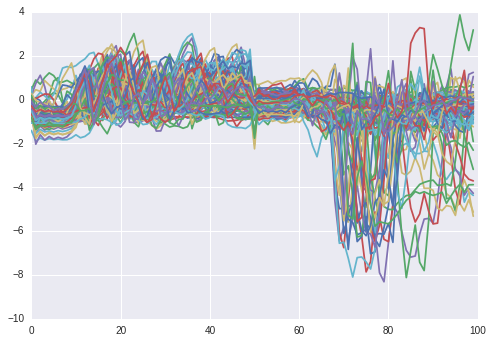

In [24]:
both_c, tt_c, ch_c, clean, s_c, ab_c = data_parser(theta,kappa,tt,ch,sess,AB)
_ = plt.plot(both_c[:100].T)

[[293  42  47]
 [ 63 213  42]
 [ 85  25 220]]
[[180  23  28]
 [ 41 139  26]
 [ 52  47 198]]
0.704854368932
0.704359673025


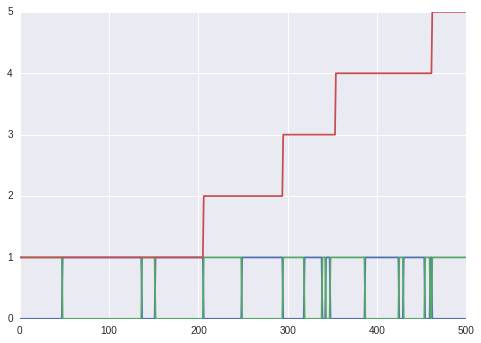

In [32]:
AB_pol = np.nan_to_num(ab_c) !=0
ON_pol = np.nan_to_num(ab_c) ==0

plt.plot(AB_pol[:500])
plt.plot(ON_pol[:500])
plt.plot(s_c[:500])

cm_AB = confusion_matrix(tt_c[AB_pol],ch_c[AB_pol])
cm_ON = confusion_matrix(tt_c[ON_pol],ch_c[ON_pol])
print(cm_AB)
print(cm_ON)
print(accuracy_score(tt_c[AB_pol],ch_c[AB_pol]))
print(accuracy_score(tt_c[ON_pol],ch_c[ON_pol]))

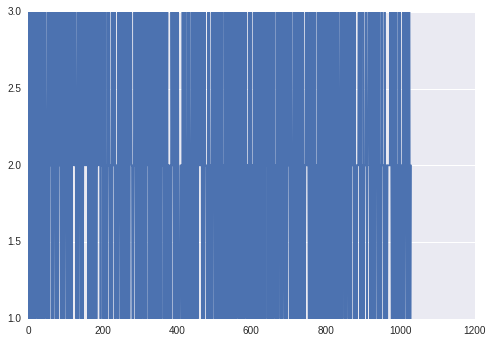

In [38]:
plt.plot(tt_c[AB_pol.squeeze()])

In [39]:
# Cross validated predictions with logistic regression for ON and rand policy
# Define models
lr = LogisticRegression()
NN = skflow.TensorFlowDNNClassifier(hidden_units=[100], n_classes=3,batch_size=128, steps=1000, optimizer = 'Adam',learning_rate=0.001,verbose=0)

preds_AB = cross_validation.cross_val_predict(lr, both_c[AB_pol.squeeze()], tt_c[AB_pol.squeeze()].squeeze()-1, cv=5)
preds_NN_AB = cross_validation.cross_val_predict(NN, both_c[AB_pol.squeeze()], tt_c[AB_pol.squeeze()].squeeze()-1, cv=5)

preds_ON = cross_validation.cross_val_predict(lr, both_c[ON_pol.squeeze()], tt_c[ON_pol.squeeze()].squeeze()-1, cv=5)
preds_NN_ON = cross_validation.cross_val_predict(NN, both_c[ON_pol.squeeze()], tt_c[ON_pol.squeeze()].squeeze()-1, cv=5)


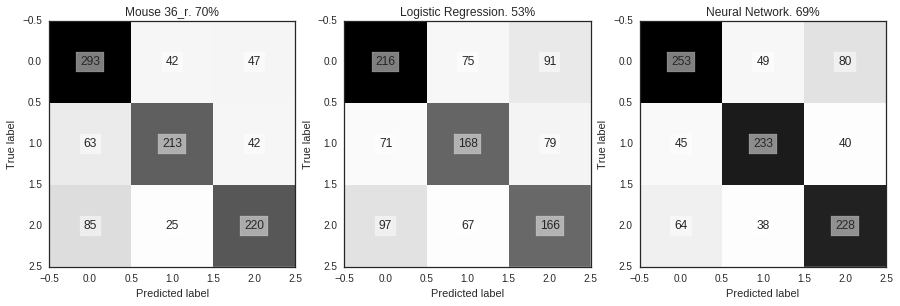

In [50]:
# TRIALTYPE - AB TRIALS
trialtypes = ['Anterior Pole','Posterior Pole','No Go']
# Confusion matrices. Mouse vs model
label = tt_c[AB_pol.squeeze()]
cm_m = confusion_matrix(label,ch_c[AB_pol.squeeze()])

# Confusion matrices
cm_lr = confusion_matrix(label,preds_AB+1)
cm_NN = confusion_matrix(label,preds_NN_AB+1)


with sns.axes_style("white"):
    fig,ax = plt.subplots(1,3,figsize=(15,6))


    ax[0].imshow(cm_m,interpolation='none',cmap="Greys")
    ax[0].set_title('Mouse ' + mouse_name + '. ' + str(int(100 * accuracy_score(label,ch_c[AB_pol.squeeze()]))) + '%')
    ax[0].set_ylabel('True label')
    ax[0].set_xlabel('Predicted label')
    tick_marks = np.arange(len(trialtypes))
    ax[0].set_xticks(tick_marks, trialtypes)
    ax[0].set_yticks(tick_marks, trialtypes)
    
    for i in range(0,3):
        for j in range(0,3):
            ax[0].text(j, i, cm_m[i,j], va='center', ha='center',bbox=dict(facecolor='white',edgecolor='white', alpha=0.5))

    ax[1].imshow(cm_lr,interpolation='none',cmap="Greys")
    ax[1].set_title('Logistic Regression' + '. ' + str(int(100 * accuracy_score(label,preds_AB+1))) + '%')
    ax[1].set_ylabel('True label')
    ax[1].set_xlabel('Predicted label')
    
    for i in range(0,3):
        for j in range(0,3):
            ax[1].text(j, i, cm_lr[i,j], va='center', ha='center',bbox=dict(facecolor='white',edgecolor='white', alpha=0.5))

    ax[2].imshow(cm_NN,interpolation='none',cmap="Greys")
    ax[2].set_title('Neural Network' + '. ' + str(int(100 * accuracy_score(label,preds_NN_AB+1))) + '%')
    ax[2].set_ylabel('True label')
    ax[2].set_xlabel('Predicted label')
    
    for i in range(0,3):
        for j in range(0,3):
            ax[2].text(j, i, cm_NN[i,j], va='center', ha='center',bbox=dict(facecolor='white',edgecolor='white', alpha=0.5))

            
plt.savefig('../figs/rand_only/Cmatrix_tt_AB_'+ mouse_name +'.png')

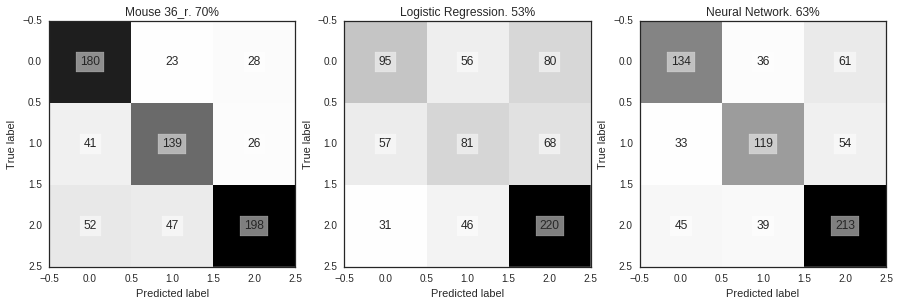

In [49]:
# TRIALTYPE - ON TRIALS
trialtypes = ['Anterior Pole','Posterior Pole','No Go']
# Confusion matrices. Mouse vs model
label = tt_c[ON_pol.squeeze()]
cm_m = confusion_matrix(label,ch_c[ON_pol.squeeze()])

# Confusion matrices
cm_lr = confusion_matrix(label,preds_ON+1)
cm_NN = confusion_matrix(label,preds_NN_ON+1)


with sns.axes_style("white"):
    fig,ax = plt.subplots(1,3,figsize=(15,6))


    ax[0].imshow(cm_m,interpolation='none',cmap="Greys")
    ax[0].set_title('Mouse ' + mouse_name + '. ' + str(int(100 * accuracy_score(label,ch_c[ON_pol.squeeze()]))) + '%')
    ax[0].set_ylabel('True label')
    ax[0].set_xlabel('Predicted label')
    tick_marks = np.arange(len(trialtypes))
    ax[0].set_xticks(tick_marks, trialtypes)
    ax[0].set_yticks(tick_marks, trialtypes)
    
    for i in range(0,3):
        for j in range(0,3):
            ax[0].text(j, i, cm_m[i,j], va='center', ha='center',bbox=dict(facecolor='white',edgecolor='white', alpha=0.5))

    ax[1].imshow(cm_lr,interpolation='none',cmap="Greys")
    ax[1].set_title('Logistic Regression' + '. ' + str(int(100 * accuracy_score(label,preds_ON+1))) + '%')
    ax[1].set_ylabel('True label')
    ax[1].set_xlabel('Predicted label')
    
    for i in range(0,3):
        for j in range(0,3):
            ax[1].text(j, i, cm_lr[i,j], va='center', ha='center',bbox=dict(facecolor='white',edgecolor='white', alpha=0.5))

    ax[2].imshow(cm_NN,interpolation='none',cmap="Greys")
    ax[2].set_title('Neural Network' + '. ' + str(int(100 * accuracy_score(label,preds_NN_ON+1))) + '%')
    ax[2].set_ylabel('True label')
    ax[2].set_xlabel('Predicted label')
    
    for i in range(0,3):
        for j in range(0,3):
            ax[2].text(j, i, cm_NN[i,j], va='center', ha='center',bbox=dict(facecolor='white',edgecolor='white', alpha=0.5))

            
plt.savefig('../figs/rand_only/Cmatrix_tt_ON_'+ mouse_name +'.png')

In [48]:
! pwd

/home/mathew/work/whiskfree/tf


In [614]:
# Let's use 20% of the data for testing and 80% for training
trainsize = int(len(both_c) * 0.8)
testsize = len(both_c) - trainsize
print('Desired training/test set sizes:',trainsize, testsize)

subset = random.sample(range(len(both_c)),trainsize)
fullrange = range(0,len(both_c))
toexclude = np.delete(fullrange,subset)
traindata = both_c[subset,:]
# trainlabs = labs[subset,:]
testdata = np.delete(both_c,subset,axis=0)
# testlabs = np.delete(labs,subset,axis=0)

# non one-hot style labels
trainlabs1D = tt_c[subset].squeeze() # Change this to ch_c to classify choice instead
testlabs1D = np.delete(tt_c,subset)

print('training set shape:',traindata.shape)
print('test set shape:',testdata.shape)
# print('training labels shape:',trainlabs.shape)
# print('test labels shape:',testlabs.shape)
print('1D train label shape:', trainlabs1D.shape)
print('1D test label shape:', testlabs1D.shape)

Desired training/test set sizes: 1640 410
training set shape: (1640, 100)
test set shape: (410, 100)
1D train label shape: (1640,)
1D test label shape: (410,)


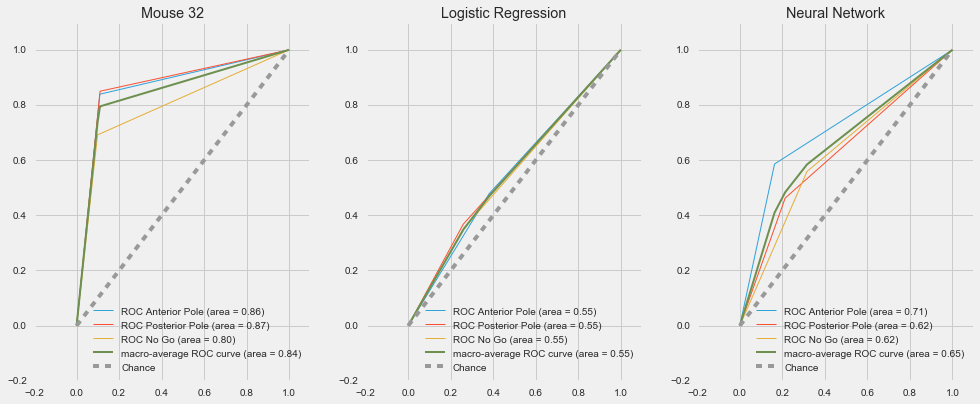

In [622]:
# ROC mouse + 2 MODELS of all trials with binarised labels
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3


trialtypes = ['Anterior Pole','Posterior Pole','No Go'] # 32-34
# trialtypes = ['Posterior Pole','Anterior Pole','No Go'] # 36

# Change the model/labels here 
preds = cross_validation.cross_val_predict(lr, both_c, ch_c.squeeze()-1, cv=5)
preds_NN = cross_validation.cross_val_predict(NN, both_c, ch_c.squeeze()-1, cv=5)

with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(1,3,figsize=(15,6))

    # MOUSE
    mouse_choice = ch[clean.squeeze()].values
    n_classes = 3
    for i in range(0,3):
        these_trials = tt_c == i+1
        binary_trials = np.zeros_like(tt_c.squeeze())    
        binary_trials[these_trials.squeeze()] = 1

        wrong = mouse_choice != i+1
        binary_preds = np.ones_like(mouse_choice)
        binary_preds[wrong] = 0
        fpr[i], tpr[i], thresholds = metrics.roc_curve(binary_trials,binary_preds)
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
        ax[0].plot(fpr[i], tpr[i], lw=1, label='ROC ' + trialtypes[i] +' (area = %0.2f)' % (roc_auc[i]))


    # Compute macro-average ROC following sklearn docs

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    # Finally average it and compute AUC
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])
    ax[0].plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'''.format(roc_auc["macro"]),linewidth=2)

    ax[0].plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Chance')
    ax[0].legend(loc=4)
    ax[0].set_title('Mouse ' + mouse_name)
    ax[0].set_xlim([-0.2,1.1])
    ax[0].set_ylim([-0.2,1.1])

    # Logistic Regression
    for i in range(0,3):
        these_trials = tt_c == i+1
        binary_trials = np.zeros_like(tt_c.squeeze())    
        binary_trials[these_trials.squeeze()] = 1

        wrong = preds != i
        binary_preds = np.ones_like(preds)
        binary_preds[wrong] = 0
        fpr[i], tpr[i], thresholds = metrics.roc_curve(binary_trials,binary_preds)
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
        ax[1].plot(fpr[i], tpr[i], lw=1, label='ROC ' + trialtypes[i] +' (area = %0.2f)' % (roc_auc[i]))


    # Compute macro-average ROC following sklearn docs

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    # Finally average it and compute AUC
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])
    ax[1].plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'''.format(roc_auc["macro"]),linewidth=2)

    ax[1].plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Chance')
    ax[1].legend(loc=4)
    ax[1].set_title('Logistic Regression')
    ax[1].set_xlim([-0.2,1.1])
    ax[1].set_ylim([-0.2,1.1])
    
    
    # Neural Network
    for i in range(0,3):
        these_trials = tt_c == i+1
        binary_trials = np.zeros_like(tt_c.squeeze())    
        binary_trials[these_trials.squeeze()] = 1

        wrong = preds_NN != i
        binary_preds = np.ones_like(preds)
        binary_preds[wrong] = 0
        fpr[i], tpr[i], thresholds = metrics.roc_curve(binary_trials,binary_preds)
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
        ax[2].plot(fpr[i], tpr[i], lw=1, label='ROC ' + trialtypes[i] +' (area = %0.2f)' % (roc_auc[i]))


    # Compute macro-average ROC following sklearn docs

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    # Finally average it and compute AUC
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])
    ax[2].plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'''.format(roc_auc["macro"]),linewidth=2)

    ax[2].plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Chance')
    ax[2].legend(loc=4)
    ax[2].set_title('Neural Network')
    ax[2].set_xlim([-0.2,1.1])
    ax[2].set_ylim([-0.2,1.1])
    
# plt.savefig('figs/ROC_allthree_trailtype_preds_'+ mouse_name +'.png')

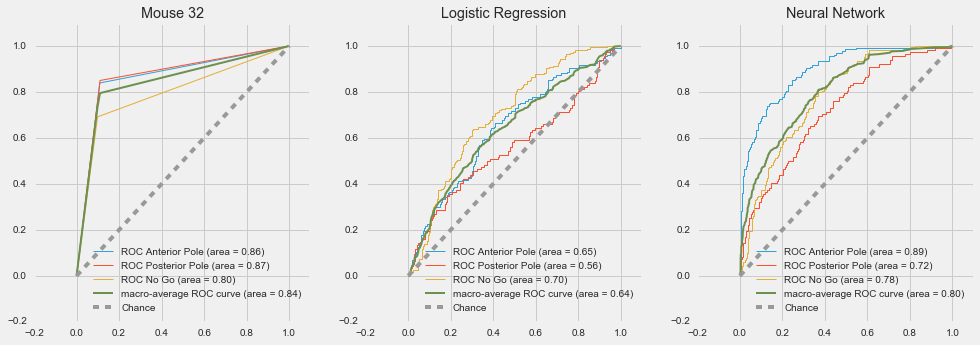

In [617]:
# Softmax probability version
# TO DO: change this to utilise all data in cross val by setting up custom function.

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3

probs = lr.fit(traindata,trainlabs1D-1).predict_proba(testdata)
probs_NN = NN.fit(traindata,trainlabs1D-1).predict_proba(testdata)

with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(1,3, figsize=(15,5))

    # MOUSE
    mouse_choice = ch[clean.squeeze()].values
    n_classes = 3
    for i in range(0,3):
        these_trials = tt_c == i+1
        binary_trials = np.zeros_like(tt_c.squeeze())    
        binary_trials[these_trials.squeeze()] = 1

        wrong = mouse_choice != i+1
        binary_preds = np.ones_like(mouse_choice)
        binary_preds[wrong] = 0
        fpr[i], tpr[i], thresholds = metrics.roc_curve(binary_trials,binary_preds)
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
        ax[0].plot(fpr[i], tpr[i], lw=1, label='ROC ' + trialtypes[i] +' (area = %0.2f)' % (roc_auc[i]))


    # Compute macro-average ROC following sklearn docs

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    # Finally average it and compute AUC
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])
    ax[0].plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'''.format(roc_auc["macro"]),linewidth=2)
    ax[0].plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Chance')
    ax[0].legend(loc=4)
    ax[0].set_title('Mouse ' + mouse_name)
    ax[0].set_xlim([-0.2,1.1])
    ax[0].set_ylim([-0.2,1.1])
    
    # Logistic Regression
    for i in range(0,3):
        these_trials = testlabs1D == i+1
        binary_trials = np.zeros_like(testlabs1D.squeeze())
        binary_trials[these_trials.squeeze()] = 1

        fpr[i], tpr[i], thresholds = metrics.roc_curve(binary_trials,probs[:,i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
        ax[1].plot(fpr[i], tpr[i], lw=1, label='ROC ' + trialtypes[i] +' (area = %0.2f)' % (roc_auc[i]))


    # Compute macro-average ROC following sklearn docs
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    # Finally average it and compute AUC
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])
    ax[1].plot(fpr["macro"], tpr["macro"],label='macro-average ROC curve (area = {0:0.2f})'''.format(roc_auc["macro"]),linewidth=2)
    ax[1].plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Chance')
    ax[1].legend(loc=4)
    ax[1].set_title('Logistic Regression')
    ax[1].set_xlim([-0.2,1.1])
    ax[1].set_ylim([-0.2,1.1])

    # Neural Network
    for i in range(0,3):
        these_trials = testlabs1D == i+1
        binary_trials = np.zeros_like(testlabs1D.squeeze())
        binary_trials[these_trials.squeeze()] = 1

        fpr[i], tpr[i], thresholds = metrics.roc_curve(binary_trials,probs_NN[:,i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
        ax[2].plot(fpr[i], tpr[i], lw=1, label='ROC ' + trialtypes[i] +' (area = %0.2f)' % (roc_auc[i]))


    # Compute macro-average ROC following sklearn docs
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    # Finally average it and compute AUC
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])
    ax[2].plot(fpr["macro"], tpr["macro"],label='macro-average ROC curve (area = {0:0.2f})'''.format(roc_auc["macro"]),linewidth=2)
    ax[2].plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Chance')
    ax[2].legend(loc=4)
    ax[2].set_title('Neural Network')
    ax[2].set_xlim([-0.2,1.1])
    ax[2].set_ylim([-0.2,1.1])

# plt.savefig('figs/ROC_both_trialtype_3probs_'+ mouse_name +'.png')

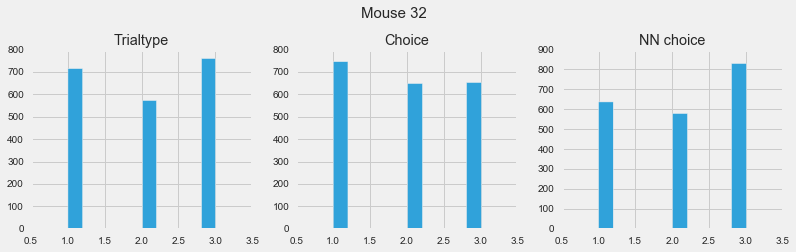

In [624]:
# preds = cross_validation.cross_val_predict(lr, both_c, tt_c.squeeze()-1, cv=5)
# plt.hist(preds)
# x = tt_c[~np.isnan(tt_c)]
# x.shape
# plt.hist(np.nan_to_num(tt))
with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(1,3, figsize=(12,3))
    ax[0].hist(tt_c)
#     ax[0].hist(tt[clean.squeeze()].values) # when predicting choice
    ax[0].set_title('Trialtype')
#     ax[0].set_xticks([1,2,3],trialtypes)
    ax[0].set_xlim([0.5,3.5])
    
    ax[1].hist(ch_c)
    ax[1].set_title('Choice')
    ax[1].set_xlim([0.5,3.5])
    
    ax[2].hist(preds_NN+1)
    ax[2].set_title('NN choice')
    ax[2].set_xlim([0.5,3.5])
    

plt.suptitle('Mouse ' + mouse_name, x=0.5,y=1.1,fontsize=15)
# plt.savefig('figs/choice_number_'+ mouse_name +'.png')

In [625]:
# print('Mouse '+ mouse_name + '. '+ accuracy_score(tt_c,mouse_choice) + '%')
# int(100 *accuracy_score(tt_c,mouse_choice))
# print('Mouse ' + mouse_name + '. ' + str(int(100 * accuracy_score(tt_c,mouse_choice))) + '%')
trialtypes = ['Anterior Pole','Posterior Pole','No Go']

print(metrics.classification_report(label,ch_c,target_names=trialtypes))
print('Weighted f1_score: ',metrics.f1_score(label,mouse_choice,average='weighted'))
print(metrics.classification_report(label,preds_NN+1,target_names=trialtypes))
print('Weighted f1_score: ',metrics.f1_score(label,preds_NN+1,average='weighted'))

                precision    recall  f1-score   support

 Anterior Pole       1.00      1.00      1.00       746
Posterior Pole       1.00      1.00      1.00       650
         No Go       1.00      1.00      1.00       654

   avg / total       1.00      1.00      1.00      2050

Weighted f1_score:  1.0
                precision    recall  f1-score   support

 Anterior Pole       0.63      0.53      0.58       746
Posterior Pole       0.50      0.44      0.47       650
         No Go       0.47      0.60      0.53       654

   avg / total       0.54      0.53      0.53      2050

Weighted f1_score:  0.527602929973


(array([ 746.,    0.,    0.,    0.,    0.,  650.,    0.,    0.,    0.,  654.]),
 array([ 1. ,  1.2,  1.4,  1.6,  1.8,  2. ,  2.2,  2.4,  2.6,  2.8,  3. ]),
 <a list of 10 Patch objects>)

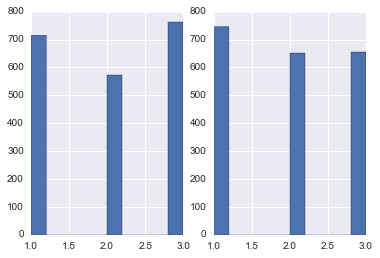

In [580]:
clean1 = np.nan_to_num(tt) !=0
clean2 = np.nan_to_num(ch) !=0
tt_c2 = tt[clean1&clean2].values
ch_c2 = ch[clean1&clean2].values
fig,ax = plt.subplots(1,2)
ax[0].hist(tt_c2)
ax[1].hist(ch_c2)

In [605]:
    theta_r = np.array([[resample(theta.values.squeeze()[i,950:1440],50)] for i in range(0,theta.shape[0])])
    theta_r = zscore(theta_r.squeeze(),axis=None)

    kappa_r = np.array([[resample(kappa.values.squeeze()[i,950:1440],50)] for i in range(0,kappa.shape[0])])
    kappa_r = zscore(kappa_r.squeeze(),axis=None)

    kappa_df = pd.DataFrame(kappa_r)
    theta_df = pd.DataFrame(theta_r)

    both_df = pd.concat([theta_df,kappa_df],axis=1)

In [610]:
clean1 = np.nan_to_num(tt) !=0
clean2 = np.nan_to_num(ch) !=0
clean = clean1&clean2

# tt_c = tt[tt.values !=0|3].values
both = both_df[clean]
# both_c = both[clean.squeeze(),:]
both_c = both.values
both_c.shape

(2050, 100)

explained variance ratio (first two components): [ 0.55555146  0.08664667  0.06440919  0.03329143  0.02657068  0.01778359
  0.01721609  0.01356244  0.01275442  0.01231425  0.01084843  0.00950096
  0.009305    0.00840834  0.00778664  0.00746098  0.00709647  0.0067303
  0.00621268  0.00603575]


/Users/mathew/miniconda/envs/py35/lib/python3.5/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


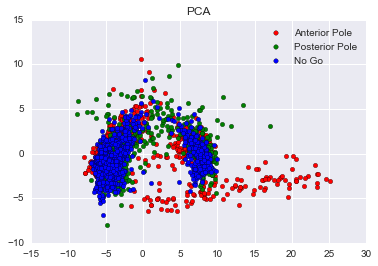

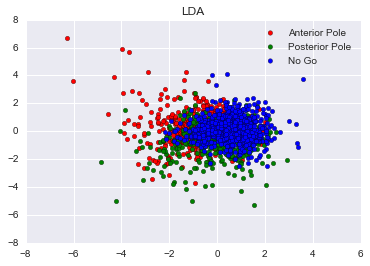

In [673]:
# LDA/PCA of data TRIALTYPE

from sklearn.lda import LDA
from sklearn.decomposition import PCA

trialtypes = ['Anterior Pole','Posterior Pole','No Go']

pca = PCA(n_components=20)
X_r = pca.fit(both_c).transform(both_c)

lda = LDA(n_components=20)
X_r2 = lda.fit(both_c, tt_c).transform(both_c)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
for c, i, trialtypes in zip("rgb", [0, 1, 2], trialtypes):
    plt.scatter(X_r[tt_c.ravel() == i+1, 0], X_r[tt_c.ravel() == i+1, 1], c=c, label=trialtypes)
plt.legend()
plt.title('PCA')

trialtypes = ['Anterior Pole','Posterior Pole','No Go']
plt.figure()
for c, i, trialtypes in zip("rgb", [0, 1, 2], trialtypes):
    plt.scatter(X_r2[tt_c.squeeze() == i+1, 0], X_r2[tt_c.squeeze() == i+1, 1], c=c, label=trialtypes)
plt.legend()
plt.title('LDA')



explained variance ratio (first two components): [ 0.55555146  0.08664667  0.06440919  0.03329143  0.02657068  0.01778359
  0.01721609  0.01356244  0.01275442  0.01231425  0.01084843  0.00950096
  0.009305    0.00840834  0.00778664  0.00746098  0.00709647  0.0067303
  0.00621268  0.00603575]


/Users/mathew/miniconda/envs/py35/lib/python3.5/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


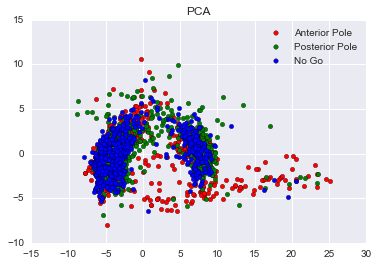

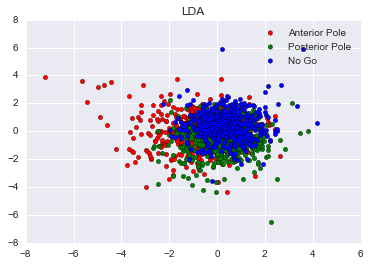

In [675]:
# LDA/ PCA CHOICE
trialtypes = ['Anterior Pole','Posterior Pole','No Go']

pca = PCA(n_components=20)
X_r = pca.fit(both_c).transform(both_c)

lda = LDA(n_components=20)
X_r2 = lda.fit(both_c, ch_c).transform(both_c)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
for c, i, trialtypes in zip("rgb", [0, 1, 2], trialtypes):
    plt.scatter(X_r[ch_c.squeeze() == i+1, 0], X_r[ch_c.squeeze() == i+1, 1], c=c, label=trialtypes)
plt.legend()
plt.title('PCA')

trialtypes = ['Anterior Pole','Posterior Pole','No Go']
plt.figure()
for c, i, trialtypes in zip("rgb", [0, 1, 2], trialtypes):
    plt.scatter(X_r2[ch_c.squeeze() == i+1, 0], X_r2[ch_c.squeeze() == i+1, 1], c=c, label=trialtypes)
plt.legend()
plt.title('LDA')


array([ 0.55555146,  0.64219813,  0.70660732,  0.73989875,  0.76646944,
        0.78425303,  0.80146912,  0.81503155,  0.82778597,  0.84010022,
        0.85094864,  0.8604496 ,  0.8697546 ,  0.87816294,  0.88594959,
        0.89341057,  0.90050703,  0.90723733,  0.91345001,  0.91948576])

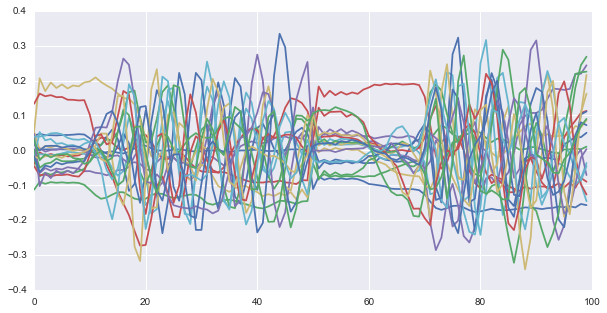

In [699]:
# lda.score(both_c,tt_c)
x = pca.components_
fig, ax = plt.subplots(figsize=(10,5))
_ = plt.plot(x.T,)
np.cumsum(pca.explained_variance_ratio_)

## Conv net & model weight inspection

In [452]:
# Conv net
def max_pool_2x1(tensor_in):
    return tf.nn.max_pool(tensor_in, ksize=[1, 2, 1, 1], strides=[1, 2, 1, 1],
        padding='SAME')

def conv_model(X, y):
    # reshape X to 4d tensor with 2nd and 3rd dimensions being image width and height
    # final dimension being the number of color channels
    X = tf.reshape(X, [-1, 100, 1, 1])
    # first conv layer will compute 32 features for each 5x1 strip
    with tf.variable_scope('conv_layer1'):
        h_conv1 = skflow.ops.conv2d(X, n_filters=32, filter_shape=[5, 1], 
                                    bias=True, activation=tf.nn.relu)
        h_pool1 = max_pool_2x1(h_conv1)
    # second conv layer will compute 64 features for each 5x1 strip
    with tf.variable_scope('conv_layer2'):
        h_conv2 = skflow.ops.conv2d(h_pool1, n_filters=64, filter_shape=[5, 1], 
                                    bias=True, activation=tf.nn.relu)
        h_pool2 = max_pool_2x1(h_conv2)
        # reshape tensor into a batch of vectors
        h_pool2_flat = tf.reshape(h_pool2, [-1, 5 * 5 * 64])
    # densely connected layer with 1024 neurons
    h_fc1 = skflow.ops.dnn(h_pool2_flat, [1024], activation=tf.nn.relu, dropout=0.5)
    return skflow.models.logistic_regression(h_fc1, y)

# Training and predicting
classifier3 = skflow.TensorFlowEstimator(
    model_fn=conv_model, n_classes=10, batch_size=100, steps=20000,
    learning_rate=0.001)

In [130]:
# Convnet
convnet = skflow.TensorFlowEstimator(
    model_fn=conv_model, n_classes=10, batch_size=100, steps=20000,
    learning_rate=0.001,verbose=0)

# convnet.fit(traindata,trainlabs1D-1)
# lr.fit(both_c,tt_c.squeeze())
# print(accuracy_score(testlabs1D-1,convnet.predict(testdata)))

scores_convnet = cross_validation.cross_val_score(convnet, both_c, tt_c.squeeze()-1, cv=5,scoring='accuracy') #'f1_weighted')

print(scores_convnet)
print(np.mean(scores_convnet))

[ 0.32294618  0.32577904  0.36543909  0.32294618  0.34090909]
0.335603914499


In [676]:
# Logistic regression (once)
lr = LogisticRegression()
lr.fit(X_r2,tt_c)
# lr.fit(both_c,tt_c.squeeze())

# print(accuracy_score(testlabs1D,lr.predict(testdata)))
print(accuracy_score(ch_c.squeeze(),lr.predict(X_r2)))
lr.fit(both_c,ch_c)
print(accuracy_score(ch_c.squeeze(),lr.predict(both_c)))

/Users/mathew/miniconda/envs/py35/lib/python3.5/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mathew/miniconda/envs/py35/lib/python3.5/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.508292682927
0.521951219512


In [696]:
# Logistic regression with 5-fold cross validation
lr = LogisticRegression()
scores_lr = cross_validation.cross_val_score(lr, both_c, tt_c.squeeze(), cv=5,scoring='accuracy')

print(scores_lr)
print(np.mean(scores_lr))

[ 0.37956204  0.47445255  0.45365854  0.46699267  0.48655257]
0.45224367348


In [698]:
# 3 diff single layer NNs
# import tensorflow.contrib.learn as skflow

hidden = [3,10,50,100]

for i in range(3):
    NN = skflow.TensorFlowDNNClassifier(hidden_units=[hidden[i]], n_classes=3,batch_size=128, steps=1000, optimizer = 'Adam',learning_rate=0.001,verbose=0)

    scores_NN = cross_validation.cross_val_score(NN, both_c, tt_c.squeeze()-1, cv=5,scoring='f1_weighted')

    print(str(hidden[i]) + ' hidden units: ' + str(scores_NN))
    print('Mean: '+ str(np.mean(scores_NN)))

3 hidden units: [ 0.33179083  0.42982541  0.50764433  0.4572466   0.52725829]
Mean: 0.450753089149
10 hidden units: [ 0.43184729  0.51731397  0.52500555  0.57368298  0.64000523]
Mean: 0.537571003873
50 hidden units: [ 0.39821852  0.53571012  0.51560305  0.62229381  0.68227708]
Mean: 0.550820516856


In [694]:
print('Mean: ', np.mean(scores_NN),'blah',1)

Mean:  0.537571003873 blah 1


In [197]:
# One hidden layer neural network

NN = skflow.TensorFlowDNNClassifier(hidden_units=[100], n_classes=3,batch_size=128, steps=1000, optimizer = 'Adam',learning_rate=0.001,verbose=0)

scores_NN1 = cross_validation.cross_val_score(NN, both_c, tt_c.squeeze()-1, cv=5,scoring='f1_weighted')

print(scores_NN1)
print(np.mean(scores_NN1))

[ 0.66369289  0.75233545  0.74937916  0.66041971  0.58509503]
0.682184449569


In [199]:
# Deep net with dropout
def my_model(X, y):
    """This is DNN with 10, 20, 10 hidden layers, and dropout of 0.5 probability."""
    layers = skflow.ops.dnn(X, [10, 20, 10], dropout=0.5)
    return skflow.models.logistic_regression(layers, y)

NN_drop = skflow.TensorFlowEstimator(model_fn=my_model, n_classes=3,batch_size=128, steps=2000, optimizer = 'Adam',learning_rate=0.01,verbose=1)
scores_NN_drop = cross_validation.cross_val_score(NN_drop, both_c, tt_c.squeeze()-1, cv=5,scoring='accuracy') #'f1_weighted')

print(scores_NN_drop)
print(np.mean(scores_NN_drop))

Step #100, epoch #8, avg. train loss: 1.14869
Step #200, epoch #16, avg. train loss: 1.04110
Step #300, epoch #25, avg. train loss: 1.01401
Step #400, epoch #33, avg. train loss: 1.00868
Step #500, epoch #41, avg. train loss: 0.99367
Step #600, epoch #50, avg. train loss: 0.99882
Step #700, epoch #58, avg. train loss: 0.97174
Step #800, epoch #66, avg. train loss: 0.94220
Step #900, epoch #75, avg. train loss: 0.94878
Step #1000, epoch #83, avg. train loss: 0.95615
Step #1100, epoch #91, avg. train loss: 0.96497
Step #1200, epoch #100, avg. train loss: 0.94810
Step #1300, epoch #108, avg. train loss: 0.96115
Step #1400, epoch #116, avg. train loss: 0.94362
Step #1500, epoch #125, avg. train loss: 0.93616
Step #1600, epoch #133, avg. train loss: 0.92822
Step #1700, epoch #141, avg. train loss: 0.94027
Step #1800, epoch #150, avg. train loss: 0.92864
Step #1900, epoch #158, avg. train loss: 0.92282
Step #2000, epoch #166, avg. train loss: 0.94435
Step #100, epoch #8, avg. train loss: 1.1

In [259]:
# SVM
from sklearn import svm
lin_svm = svm.LinearSVC()
scores_svm = cross_validation.cross_val_score(lin_svm,  both_c, tt_c.squeeze(),cv=5,scoring='accuracy')
print(scores_svm)
print(np.mean(scores_svm))

[ 0.53107345  0.5480226   0.5184136   0.51988636  0.49287749]
0.522054699889


In [248]:
# Naive bayes
cross_validation.cross_val_predict?

In [140]:
# Test all 3 models with all of the data (will overfit but we'll try and fix this later...)
lr.fit(both_c,tt_c.squeeze())
NN.fit(both_c,tt_c.squeeze()-1)
# NN_drop.fit(both_c,tt_c.squeeze()-1)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [137]:
print('Log Reg: ',accuracy_score(tt_c.squeeze(),lr.predict(both_c)))
print('NN: ',accuracy_score(tt_c.squeeze()-1,NN.predict(both_c)))
print('Deep NN: ',accuracy_score(tt_c.squeeze()-1,NN_drop.predict(both_c)))

Log Reg:  0.456349206349
NN:  0.989795918367
Deep NN:  0.537414965986


In [523]:
# plt.scatter(theta,kappa)
tt1 = tt == 1
sum(tt1)
t = theta.values
t2 = t[tt1.squeeze()]
t2.shape
# tt1.shape
# fig, ax = plt.subplots(figsize=(10,5))
# _ =plt.plot(t[tt1.squeeze()])



/Users/mathew/miniconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


(2177, 5000)

In [517]:
# plt.plot(tt_c[these_trials])
# plt.imshow(both_c[these_trials.squeeze()],aspect = 0.1)
# both_c.shape
# these_trials.shape
# plt.plot(NN.predict(both_c[these_trials.squeeze()]))
# plt.plot(tt_c[these_trials.squeeze()]-1)
# preds.shape
# wrong.shape
# binary_preds
# tt_c[these_trials.squeeze()]
# i?
# np.ones_like(binary_preds)
# NN.predict_proba(both_c[these_trials.squeeze()]).shape
# tt_c.shape
trialtypes = ['Left','Right','No Go']
trialtypes[1]

'Right'

In [122]:
classifier.fit(both_c,tt_c.squeeze()-1)

Step #100, epoch #5, avg. train loss: 1.35360
Step #200, epoch #11, avg. train loss: 1.20178
Step #300, epoch #16, avg. train loss: 1.16640
Step #400, epoch #22, avg. train loss: 1.13603
Step #500, epoch #27, avg. train loss: 1.12254
Step #600, epoch #33, avg. train loss: 1.11399
Step #700, epoch #38, avg. train loss: 1.10485
Step #800, epoch #44, avg. train loss: 1.09972
Step #900, epoch #50, avg. train loss: 1.09586
Step #1000, epoch #55, avg. train loss: 1.09505
Step #1100, epoch #61, avg. train loss: 1.09069
Step #1200, epoch #66, avg. train loss: 1.08123
Step #1300, epoch #72, avg. train loss: 1.07818
Step #1400, epoch #77, avg. train loss: 1.07795
Step #1500, epoch #83, avg. train loss: 1.07521
Step #1600, epoch #88, avg. train loss: 1.06800
Step #1700, epoch #94, avg. train loss: 1.06861
Step #1800, epoch #100, avg. train loss: 1.06602
Step #1900, epoch #105, avg. train loss: 1.05996
Step #2000, epoch #111, avg. train loss: 1.05853
Step #2100, epoch #116, avg. train loss: 1.0569

TensorFlowEstimator(batch_size=100, class_weight=None, clip_gradients=5.0,
          config=None, continue_training=False, learning_rate=0.001,
          model_fn=<function conv_model at 0x11bb8af28>, n_classes=10,
          optimizer='Adagrad', steps=20000, verbose=1)

In [124]:
accuracy_score(tt_c.squeeze()-1,classifier.predict(both_c))

0.82256235827664403

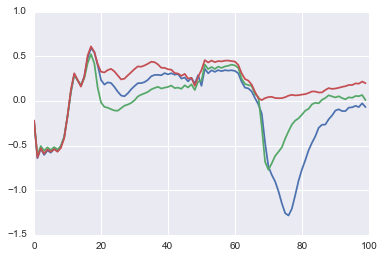

In [193]:

plt.plot(np.mean(both_c[tt_c.squeeze() ==1],0))
plt.plot(np.mean(both_c[tt_c.squeeze() ==2],0))
plt.plot(np.mean(both_c[tt_c.squeeze() ==3],0))

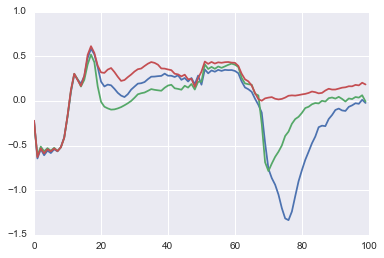

In [194]:
plt.plot(np.mean(traindata[trainlabs1D.squeeze() ==1],0))
plt.plot(np.mean(traindata[trainlabs1D.squeeze() ==2],0))
plt.plot(np.mean(traindata[trainlabs1D.squeeze() ==3],0))

array([ True,  True,  True, ...,  True, False,  True], dtype=bool)

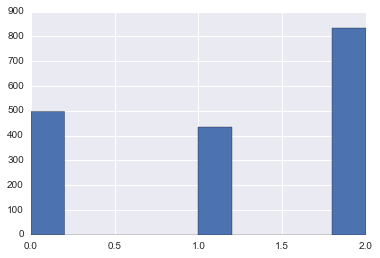

In [207]:
plt.hist(preds)
wrong